<a href="https://colab.research.google.com/github/mattlamachado/King_County_DNC/blob/main/34012_Roof_Imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# King County opção de investimento
5 imóveis que ela deveria investir e o porquê e quais 5 você não recomendaria o investimento de jeito nenhum.

In [132]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# import geopandas as gpd

roof = pd.read_csv('kingcounty/kc_house_data.csv')

In [133]:
roof.info()
roof_c = roof.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## Diferentes ZIPcodes de King County

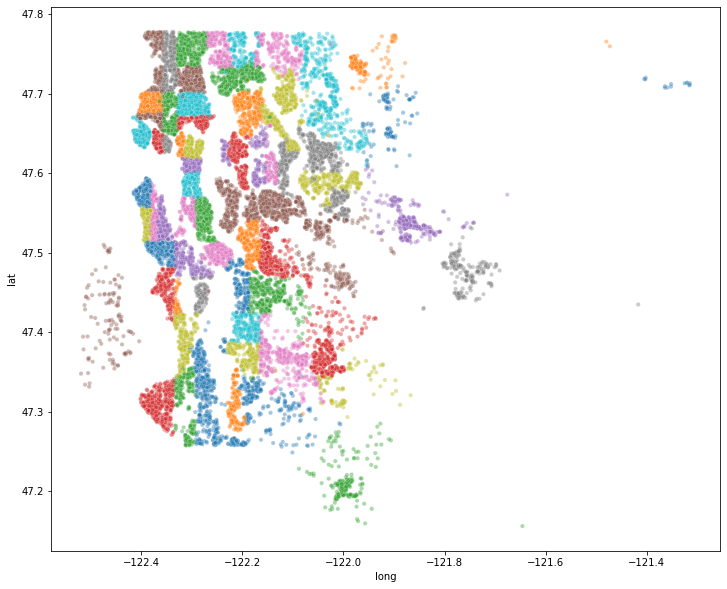

In [134]:
plt.figure(figsize=[12,10])
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, alpha=0.4, legend=False, hue = roof_c['zipcode'], palette='tab10')
plt.show()

## Insights
- Calcule o lucro/ perda de investimento caso o imóvel seja vendido mais de uma vez naquele período.


## Definição de Preço por pé<sup>2</sup>

In [135]:
roof_c['price_sqft'] = roof_c['price']/roof_c['sqft_living']
print(roof_c['price_sqft'])

0        188.050847
1        209.338521
2        233.766234
3        308.163265
4        303.571429
            ...    
21608    235.294118
21609    173.160173
21610    394.216667
21611    250.000000
21612    318.627451
Name: price_sqft, Length: 21613, dtype: float64


## Cálculo do Z score do \$/pé<sup>2</sup>
z-score = (valor - média)/desvpad

Neste caso o ideal era calcular o z-score baseade na média do valor do imóvel dentro de um raio de procura, tipo 5 km.
Ou a média por "bairro", ou seja 'zipcode'.


Primeiramente, o z-score foi calculado considerando a média e desviopadrão para tds os imóveis, consequentemente, os imóveis das áreas mais ricas ficaram supervalorizados, mas quando faz-se o z-score comparando o valor com os imóveis de mesmo ZIPcode, a realidade muda bastante, oportunidades de investimentos em áreas nobres passam a surgir, pois em comparação as redondezas, esses imóveis estão com um preço atrativo.

### z-score antigo

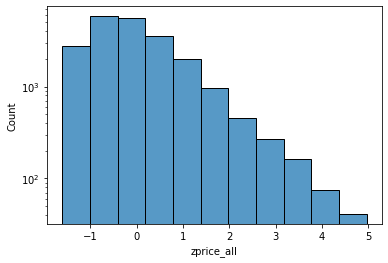

In [136]:
roof_c['zprice_all'] = pd.Series( (roof_c['price_sqft'] - (np.mean(roof_c['price_sqft']))) / np.std(roof_c['price_sqft']))

plt.figure()
sns.histplot(roof_c['zprice_all'], bins=11)
plt.yscale('log')
plt.show()




### z-score novo

In [137]:
for i,n in enumerate(roof_c['zipcode']):
    roof_c.loc[i, 'zprice'] = (roof_c.loc[i, 'price_sqft'] - np.mean(roof_c['price_sqft'][roof_c['zipcode'] == n])) / np.std(roof_c['price_sqft'][roof_c['zipcode'] == n])

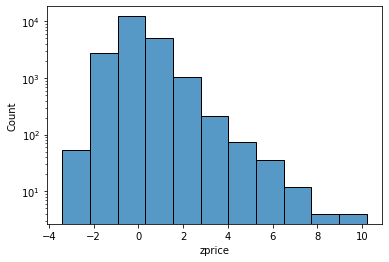

In [138]:
plt.figure()
sns.histplot(roof_c['zprice'], bins=11)
plt.yscale('log')
plt.show()

## Cálculo da diferença do tamanho do imóvel em relação a vizinhança
Quão discrepante for o imóvel, para mais ou para menos em relação a vizinhança, menor vai ser o score final, assumindo que nenhum comprador queira adquirir um imóvel fora dos padrões da vizinhança.

O Valor foi elevado ao quadrado para o efeito da discrepância não ser linear.

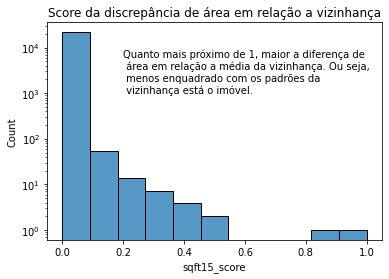

In [154]:
roof_c['sqft15_score'] = np.abs(roof_c['sqft_living'] - roof_c['sqft_living15'])**2
roof_c['sqft15_score'] /= max(roof_c['sqft15_score'])

plt.figure()
plt.title('Score da discrepância de área em relação a vizinhança')
sns.histplot(roof_c['sqft15_score'], bins=11)
plt.yscale('log')
anotacao = 'Quanto mais próximo de 1, maior a diferença de \n área em relação a média da vizinhança. Ou seja, \n menos enquadrado com os padrões da \n vizinhança está o imóvel.'
plt.annotate(anotacao, (0.2, 1000), )
plt.show()

## Contrução do Score do imóvel

Dividindo as variáves pelos seus ranges, trazendo todas para a mesma escala entre 0-1:

$Score = Log10(( ('waterfront') + ('view'/4) + ('condition'/5) + ('grade'/13) + (('yr\_built' - 1900)/115) + (('yr\_renovated' - 1900)/115)*0.5 - ('sqft15_score') ) / ('zprice' + abs(min('zprice')) + 1 ))$

As variáveis do numerador ***aumentam o grau de atratividade*** de investimento em um imóvel, exceto ***'sqft15_score'*** o ***z-score*** representa quão distante da média o \$/m<sup>2</sup> está em relação ao King County em geral. ***Dividindo o score pelo z-score***, os imóveis com maiores valores de z-score, ou seja, com ***\$/m<sup>2</sup> muito acima da média, estão superprecificadas e tem seu score reduzido proporcionalmente***, reduzindo a tratividade de investimento.

In [140]:
roof_c['SCORE'] = (( (roof_c['waterfront']) + (roof_c['view']/4) + (roof_c['condition']/5) + (roof_c['grade']/13) + ((roof_c['yr_built'] - 1900)/115) + ((roof_c['yr_renovated'])/2015)*0.5 - (roof_c['sqft15_score'])) / (roof_c['zprice'] + abs(min(roof_c['zprice']) + 1)))

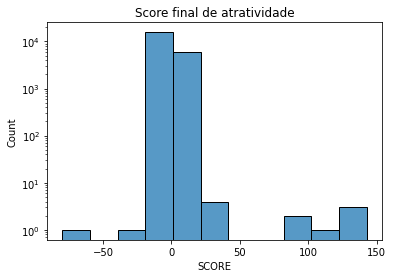

In [141]:
plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE'], bins=11)
plt.yscale('log')
plt.show()

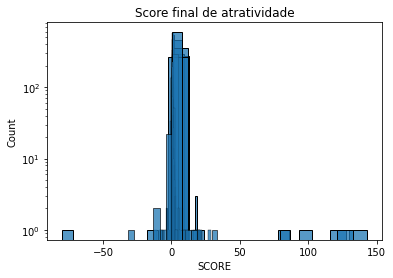

In [157]:
plt.figure()
plt.title('Score final de atratividade')

for i in set(roof_c['zipcode']):
    sns.histplot(roof_c['SCORE'][roof_c['zipcode'] == i], bins=11)
plt.yscale('log')
plt.show()

## SCORE método antigo

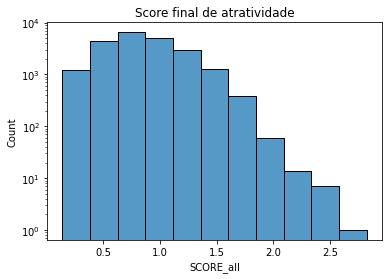

In [142]:
roof_c['SCORE_all'] = (( (roof_c['waterfront']) + (roof_c['view']/4) + (roof_c['condition']/5) + (roof_c['grade']/13) + ((roof_c['yr_built'] - 1900)/115) + ((roof_c['yr_renovated'])/2015)*0.5 - (roof_c['sqft15_score'])) / (roof_c['zprice_all'] + abs(min(roof_c['zprice_all'])) + 1))

plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE_all'], bins=11)
plt.yscale('log')
plt.show()

## 5 imóveis mais atrativos para investimento

In [143]:
display(roof_c.sort_values('SCORE', axis=0, ascending=False, inplace=False).head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice_all,zprice,sqft15_score,SCORE,SCORE_all
5774,1775800280,20150226T000000,310000.0,5,2.0,2900,11970,2.0,0,0,...,47.7410,-122.095,1260,12398,106.896552,-1.428880,-2.393297,0.035616,142.646133,1.618840
881,2349300060,20150212T000000,200000.0,4,2.0,1920,4822,1.0,0,0,...,47.5507,-122.381,1120,4822,104.166667,-1.453684,-2.399307,0.008475,133.000634,0.847188
9704,7452500565,20140829T000000,260000.0,3,2.0,2710,5000,2.0,0,0,...,47.5188,-122.373,850,5000,95.940959,-1.528424,-2.395170,0.045813,127.260233,1.356272
19188,7942601475,20140520T000000,345600.0,5,3.5,2800,5120,2.5,0,0,...,47.6059,-122.310,1780,5120,123.428571,-1.278669,-2.389093,0.013777,102.726180,1.359437
17197,5111400086,20140512T000000,110000.0,3,1.0,1250,53143,1.0,0,0,...,47.4235,-122.051,1820,217800,88.000000,-1.600576,-2.385375,0.004302,86.941960,1.841650


## 5 imóveis menos atrativos para investimento

In [144]:
display(roof_c.sort_values('SCORE', axis=0, ascending=True, inplace=False).head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice_all,zprice,sqft15_score,SCORE,SCORE_all
9417,9828701565,20150209T000000,375000.0,3,2.00,2240,5200,1.0,0,0,...,47.6191,-122.296,1470,3775,167.410714,-0.879043,-2.426690,0.007851,-79.796880,0.927490
15222,1424069069,20140522T000000,1150000.0,6,4.50,6040,219542,2.0,0,0,...,47.5622,-122.003,2010,32362,190.397351,-0.670184,-2.472038,0.215065,-31.587618,1.068112
16931,5016002275,20140602T000000,610000.0,5,2.50,3990,3839,1.0,0,0,...,47.6236,-122.299,2090,5000,152.882206,-1.011050,-2.556677,0.047804,-12.707951,1.196730
9297,424059100,20150327T000000,449228.0,5,2.50,3020,24750,1.0,0,0,...,47.5897,-122.179,2930,16062,148.750993,-1.048587,-2.548111,0.000107,-12.585267,1.144475
17689,6446200365,20150505T000000,605000.0,5,1.75,3240,34510,2.0,0,0,...,47.5529,-122.027,2650,28250,186.728395,-0.703520,-2.583087,0.004610,-10.664044,0.989941


## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> de todo o King County

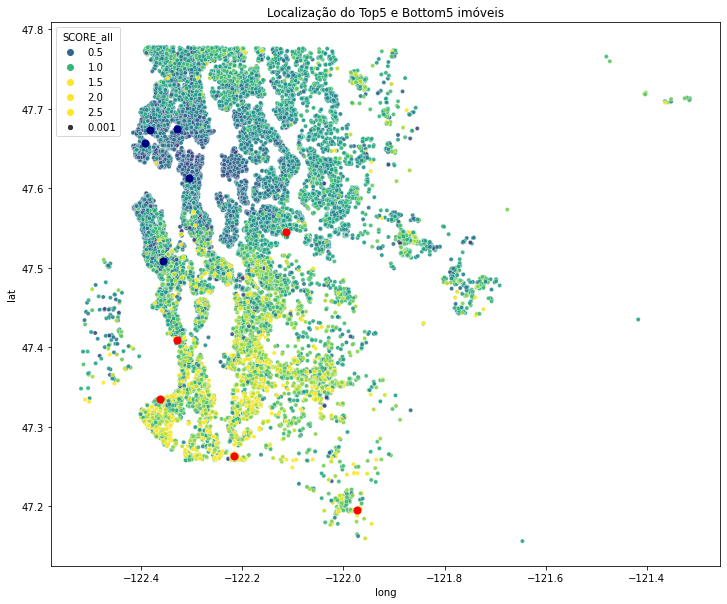

In [170]:
top5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=False, inplace=False).head()
bottom5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE_all'], palette='viridis', hue_norm=(0,1.5))

top5 = plt.scatter(top5_all['long'], top5_all['lat'], c = 'red', s = 50)
bottom5 = plt.scatter(bottom5_all['long'], bottom5_all['lat'], c = 'navy', s = 50)
# plt.legend([top5, bottom5], roof_c['SCORE'])

plt.show()

## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> por cada ZIPcode de King County

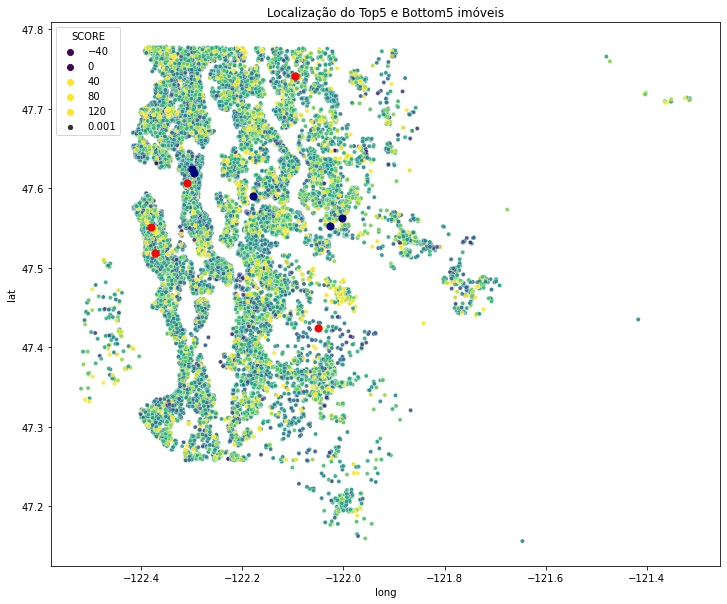

In [171]:
top5 = roof_c.sort_values('SCORE', axis=0, ascending=False, inplace=False).head()
bottom5 = roof_c.sort_values('SCORE', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE'], palette='viridis', hue_norm=(0,1.5))

plt.scatter(top5['long'], top5['lat'], c = 'red', s = 50)
plt.scatter(bottom5['long'], bottom5['lat'], c = 'navy', s = 50)
# plt.legend(roof_c['SCORE'])


plt.show()